# 1. Import Modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_ticker = pd.read_csv("ticker.csv")
print(df_ticker.head()) 
print(df_ticker.shape)

print("\nColumn Titles in df_ticker:")
print(df_ticker.columns.tolist())

                       Name    ID Ticker Exchange
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ
1               Kraft Heinz  2161    KHC   NASDAQ
2                  Fastenal  2316   FAST   NASDAQ
3                    Splunk   237   SPLK   NASDAQ
4                    Kroger  1813     KR     NYSE
(711, 4)

Column Titles in df_ticker:
['Name', 'ID', 'Ticker', 'Exchange']


In [3]:
df_ticker_description = pd.read_csv("ticker_description.csv")
print(df_ticker_description.head())

     Header                                        Description
0      Name                           The name of the company.
1        ID               A unique numeric ID for the company.
2    Ticker  The ticker symbol for the company's shares on ...
3  Exchange  The exchange on which the company's shares are...


In [4]:
df_core = pd.read_csv("core.csv")
# print(df_core.head())
print(df_core.shape)

print("\nColumn Titles in df_core:")
print(df_core.columns.tolist())

(678, 56)

Column Titles in df_core:
['Name', 'ID', 'Country', 'Website', 'Groups', 'Region', 'Stage', 'Sector', 'Description', 'AI_Publications', 'AI_Growth', 'Percentage', 'Conference_Publication', 'Citations', 'CV_publications', 'NLP_publications', 'Robotics_publications', 'Total_Publications', 'AI patents', 'Patents_Growth', 'Patent_Percentage', 'Granted_AI_patents', 'Total_patents', 'Agriculture', 'Banking_n_Finance', 'Business', 'Computing_In_Government', 'Document_Management_n_Publishing', 'Education', 'Energy', 'Entertainment', 'Industry_n_Manufacturing', 'Life_Sciences', 'Military', 'Nanotechnology', 'Networking', 'Personal_Devices_N_Computing', 'Physical_Sciences_n_Engineering', 'Security', 'Semiconductors', 'Telecommunications', 'Transportation', 'Analytics_n_Algorithms', 'Computer_Vision', 'Control', 'Distributed_AI', 'Knowledge_Representation', 'Language_Processing', 'Measuring_n_Testing', 'Planning_n_Scheduling', 'Robotics', 'Speech_Processing', 'Workforce_AI_workers', 'W

In [5]:
df_core_description = pd.read_csv("core_description.csv")
print(df_core_description.head())

  Variable Name                                        Description
0          Name                 The canonical name of the company.
1            ID               A unique numeric ID for the company.
2       Country  The country where the company's headquarters i...
3       Website                            The company's homepage.
4        Groups          Thematic groups that include the company.


# 2. Summarise and report AI growth for companies listed in different stock exchanges

An initial look through the ticker csv, we can see that a company can be listed under multiple stock exchanges

In [6]:
# We first sort by different stock exchanges
# Get unique Name and Exchange pairs from df_ticker
df_unique_listings = df_ticker.drop_duplicates(subset=["Name", "Exchange"])



print(df_unique_listings.head())
print(df_unique_listings.shape)

                       Name    ID Ticker Exchange
0  C. H. Robinson Worldwide  2239   CHRW   NASDAQ
1               Kraft Heinz  2161    KHC   NASDAQ
2                  Fastenal  2316   FAST   NASDAQ
3                    Splunk   237   SPLK   NASDAQ
4                    Kroger  1813     KR     NYSE
(594, 4)


In [7]:
# Number of companies per Exchange
company_count = df_unique_listings['Exchange'].value_counts()
print(company_count)

Exchange
NYSE      408
NASDAQ    166
HKG        14
SSE         3
SZSE        3
Name: count, dtype: int64


In [8]:
# Combine df_unique_listings with Columns regarding to AI metrics where name matches in df_core

ai_metrics = ["AI_Publications", "AI_Growth", "Total_Publications", "AI patents", 
              "Patents_Growth", "Granted_AI_patents"]

df_merged = df_unique_listings.merge(df_core, on="Name", how="left")

# we remove rows with no AI_Growth and invalid AI growth values 
df_merged = df_merged[df_merged["AI_Growth"].notna()]
df_merged = df_merged[df_merged["AI_Growth"] > -100]

print(df_merged.head())
print(df_merged.shape)

                      Name  ID_x Ticker Exchange    ID_y        Country  \
6                  Spotify   844   SPOT     NYSE   844.0         Sweden   
7                   Zillow   780      Z   NASDAQ   780.0  United States   
8                       3M   298    MMM     NYSE   298.0  United States   
9   Cadence Design Systems  2241   CDNS   NASDAQ  2241.0  United States   
11           Zimmer Biomet  2552    ZBH     NYSE  2552.0  United States   

                         Website   Groups         Region   Stage  ...  \
6         http://www.spotify.com      NaN         Europe  Mature  ...   
7          http://www.zillow.com      NaN  North America  Mature  ...   
8             https://www.3m.com  S&P 500  North America  Mature  ...   
9       https://www.cadence.com/  S&P 500  North America  Mature  ...   
11  http://www.zimmerbiomet.com/  S&P 500  North America  Mature  ...   

   Knowledge_Representation Language_Processing  Measuring_n_Testing  \
6                       6.0           

In [9]:
# Remove outliers
def remove_outliers(group):
    """
    Removes outliers from a group using the IQR method.
    """
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group >= lower_bound) & (group <= upper_bound)]

df_merged["AI_Growth"] = df_merged.groupby("Exchange")["AI_Growth"].transform(remove_outliers)


df_filtered = df_merged.copy()


# Summary of AI Growth per Exchange
summary = df_filtered.groupby('Exchange')['AI_Growth'].mean().reset_index()
summary = summary.sort_values('AI_Growth')

print("Summary of Average AI Growth by Exchange:")
print(summary)

Summary of Average AI Growth by Exchange:
  Exchange  AI_Growth
2     NYSE  27.762124
1   NASDAQ  28.346513
4     SZSE  39.623173
0      HKG  46.486481
3      SSE  82.986111


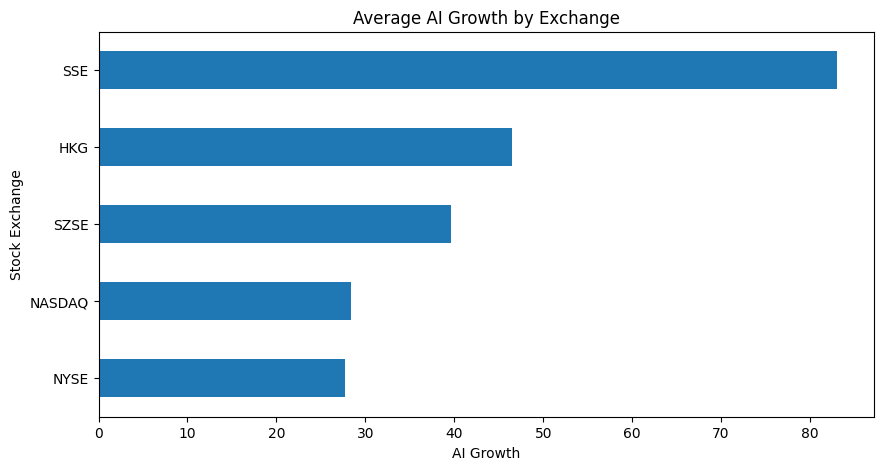

In [10]:
summary['AI_Growth'].plot(kind='barh', figsize=(10, 5), title="Average AI Growth by Exchange")
plt.xlabel("AI Growth")
plt.ylabel("Stock Exchange")
plt.yticks(ticks=range(len(summary)), labels=summary['Exchange'], fontsize=10)
plt.show()

In [11]:
ai_growth_extremes = df_filtered.groupby('Exchange')['AI_Growth'].agg(['min', 'max', 'count']).reset_index()
print("AI Growth Extremes (After Cleaning & Outlier Removal):")
print(ai_growth_extremes)

AI Growth Extremes (After Cleaning & Outlier Removal):
  Exchange        min         max  count
0      HKG  18.074120   67.608796     10
1   NASDAQ -66.666667  128.888889     59
2     NYSE -75.000000  150.000000    122
3      SSE -16.666667  263.958333      3
4     SZSE  30.532365   51.143791      3


# 3. Further analysis

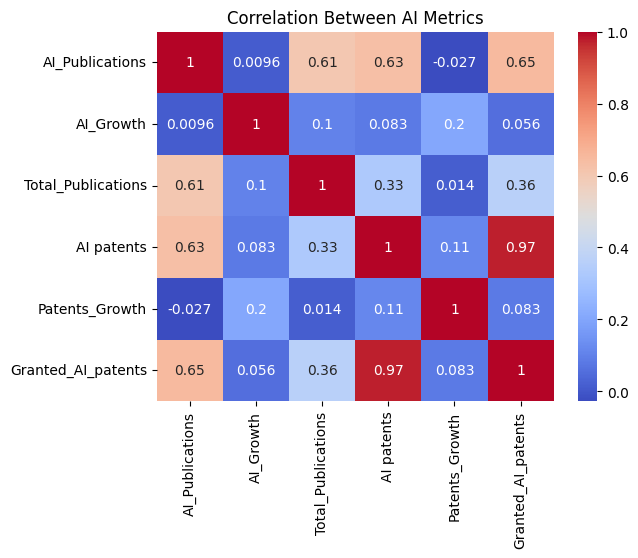

In [12]:
ai_metrics = ["AI_Publications", "AI_Growth", "Total_Publications", "AI patents", 
              "Patents_Growth", "Granted_AI_patents"]

corr_matrix = df_filtered[ai_metrics].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Between AI Metrics")
plt.show()

Strong relationship between AI patents and Granted_AI_patents (0.97), confirming that companies with more AI patent applications also tend to have more patents granted. 

Moderate positive correlation between AI_Publications and both Granted_AI_patents (0.65) and AI patents (0.63), implying that firms producing a high volume of research output are also active in seeking intellectual property protection.

correlation between AI_Growth and other metrics is weak, especially with AI_Publications (0.0096) and Total_Publications (0.1), suggesting that AI growth may not be directly tied to the number of papers or patents. 

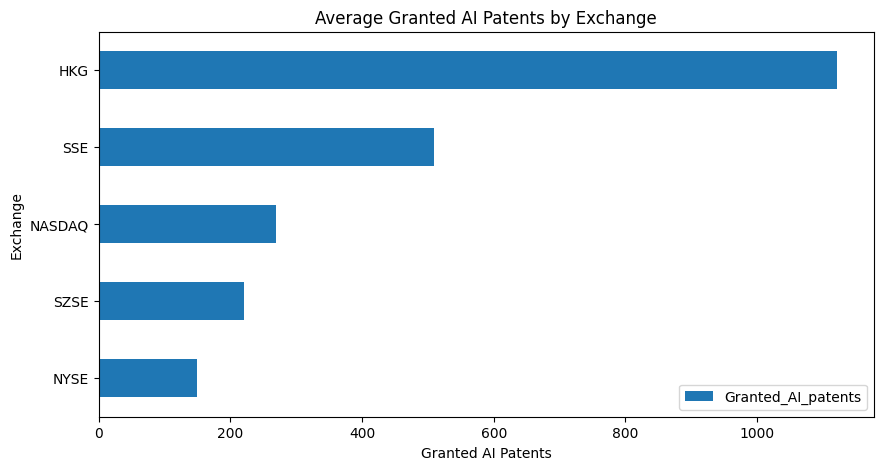

In [13]:
patents_summary = df_merged.groupby("Exchange")["Granted_AI_patents"].mean().reset_index()
patents_summary = patents_summary.sort_values("Granted_AI_patents")

patents_summary.plot(kind='barh', x='Exchange', y='Granted_AI_patents', figsize=(10, 5), 
                     title="Average Granted AI Patents by Exchange")
plt.xlabel("Granted AI Patents")
plt.show()

when looking at AI growth, SSE leads by a large margin, while HKG falls behind, even though it has more patents.However, looking at the above bar chart, HKG has the highest average number of granted AI patents, followed by the SSE. This shows a clear difference between the number of AI patents granted and the actual AI growth across stock exchanges. This difference suggests that having more patents doesn't always mean more AI growth.